## Data Wrangling

### Imports

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import os
import cv2
import numpy as np
import PIL
import PIL.Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

sns.set_style('darkgrid')

### Load Data

In [2]:
# Load train and test csv's
data_path = '../data/raw/'
train_df = pd.read_csv(filepath_or_buffer=data_path + 'train.csv')
test_df = pd.read_csv(filepath_or_buffer=data_path + 'test.csv')
print(f'Train dataset size: {train_df.shape[0]}')
print(f'Test dataset size: {test_df.shape[0]}')

Train dataset size: 3662
Test dataset size: 1928


In [3]:
# Show first 5 observations from train DF
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
# Show first 5 observations from test DF
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [5]:
# Explore different values for diagnosis
print(train_df['diagnosis'].value_counts())

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


In [6]:
print(train_df.shape)

(3662, 2)


/var/folders/wd/07w8dwy97r15by1m9klmtn700000gn/T/ipykernel_7783/4195048471.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(formatter)


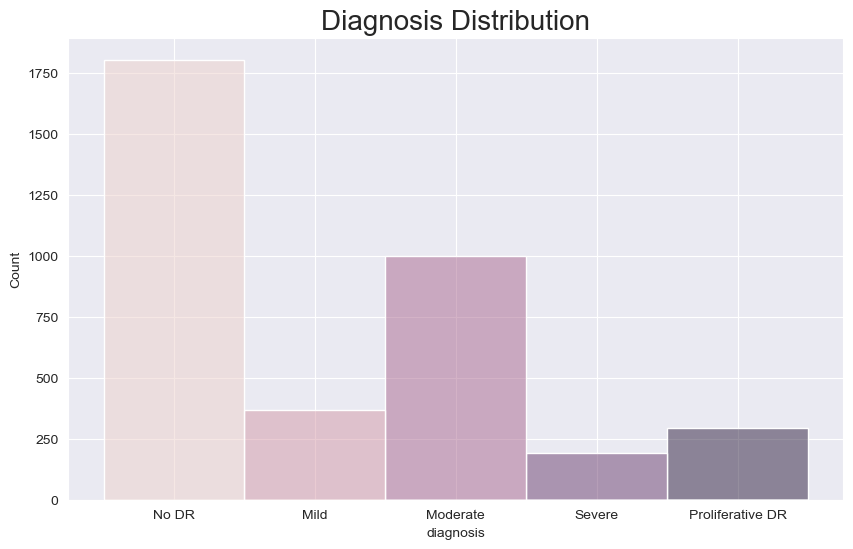

In [7]:
# Visualize diagnosis values
labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.histplot(data=train_df, x='diagnosis', discrete=True, hue='diagnosis', legend=False)
formatter = ticker.FixedFormatter(labels)
locator = ticker.FixedLocator(list(range(len(labels))))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_title("Diagnosis Distribution", fontsize=20)
plt.show()

In [8]:
### Number of missing diagnosis labels
print(train_df['diagnosis'].isna().sum())

0


The train DataFrame does not contain `Null` labels. All images have their respective diagnosis.

## Exploratory Data Analysis

### Visualize Training Images

Here, I use _matplotlib_ to show random images from the training folder.

In [9]:
# Visualize 20 images
# Create dictionary of severity labels
severity_labels = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

# Define function to preview images
def prev_images(number_rows, number_cols, train_img_path, rand_train_images, color_fltr = cv2.COLOR_BGR2RGB):
        
    # Create figure
    fig, axs= plt.subplots(
        figsize=(15, 12), 
        nrows=number_rows, ncols=number_cols,
    )

    # Iterate and show image
    idx = 0
    for i in range(number_rows):
        for j in range(number_cols):
            img = cv2.imread(train_img_path + rand_train_images[idx], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, color_fltr)
            if color_fltr == cv2.COLOR_BGR2GRAY:
                axs[i, j].imshow(img, cmap='gray')
            else:
                axs[i, j].imshow(img)

            # Hide xticks and yticks
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            ttl = train_df.loc[train_df['id_code'] == rand_train_images[idx].split('.')[0], 'diagnosis'].values[0]
            axs[i, j].set_title(severity_labels[ttl], fontsize=16)
            idx += 1
    plt.tight_layout()
    plt.show()

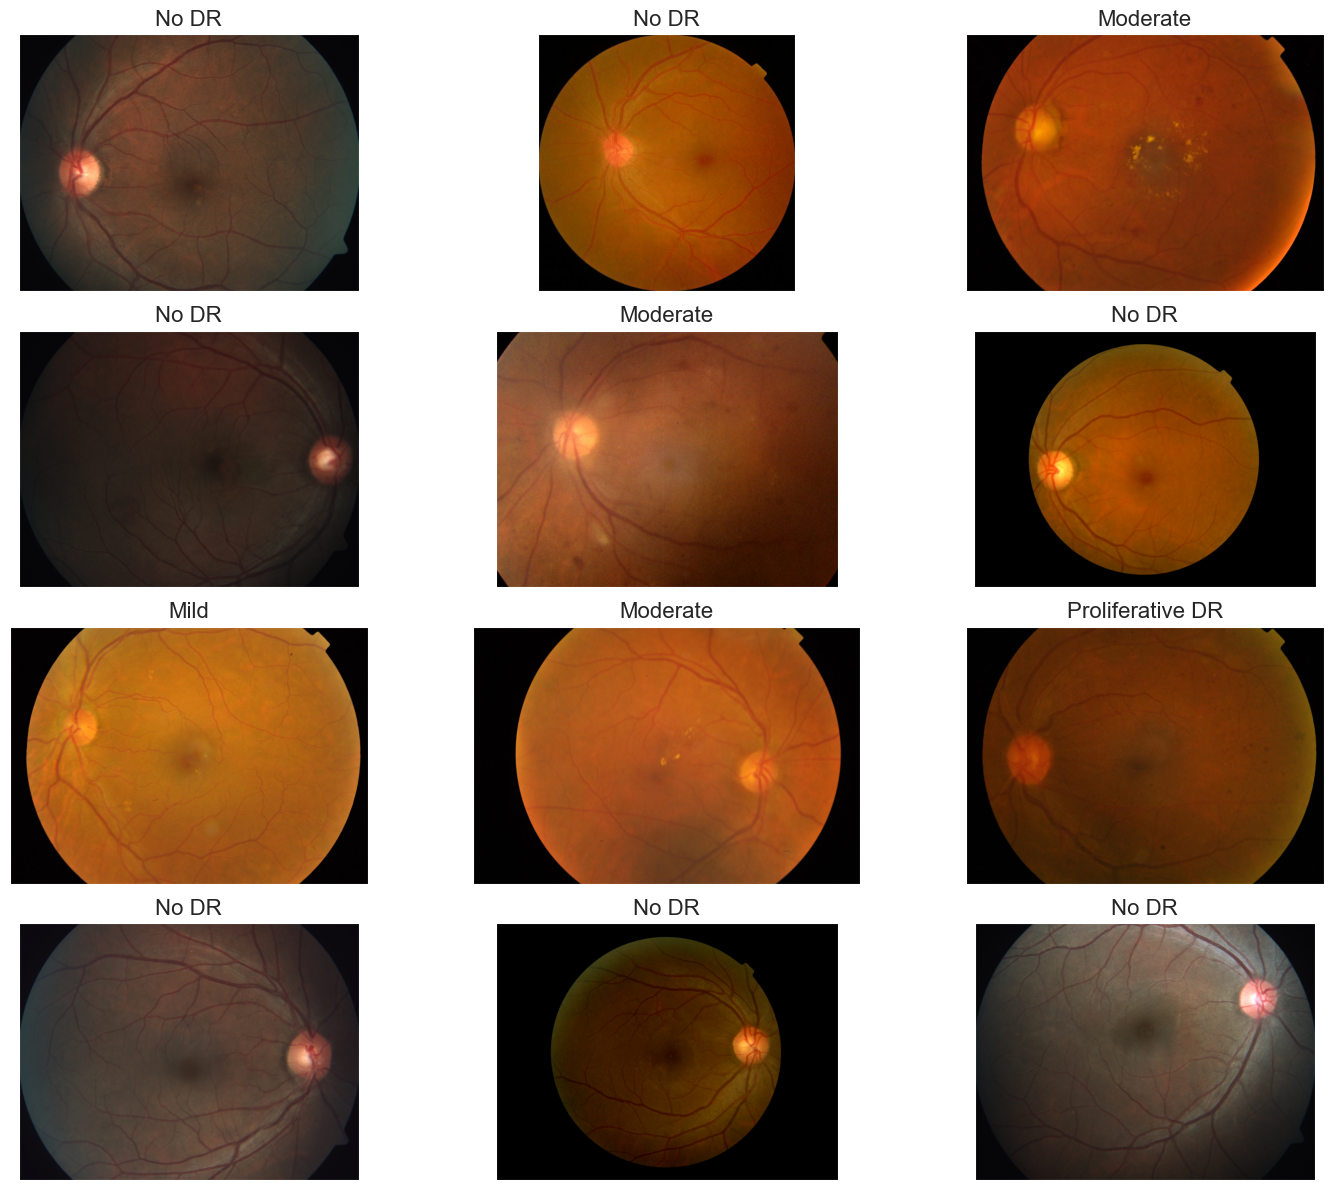

In [10]:
# Setting values for row and column variables and number of images
n_rows = 4
n_cols = 3
n_imgs = 12

# Read images
train_img_path = os.path.join(data_path, 'train_images/')

# Select 20 random images 
train_images = os.listdir(train_img_path)
rand_imgs = np.random.choice(train_images, size=n_imgs, replace=False)

# Call function to visualize images
prev_images(n_rows, n_cols, train_img_path, rand_imgs)

Images in a dataset fo not ussually have the same pixel intensity and dimensions. In this part, I will pre-process the dataset by standardizing the pixel value.

Let's try GRAY scale to see if it's possible to differentiate better.

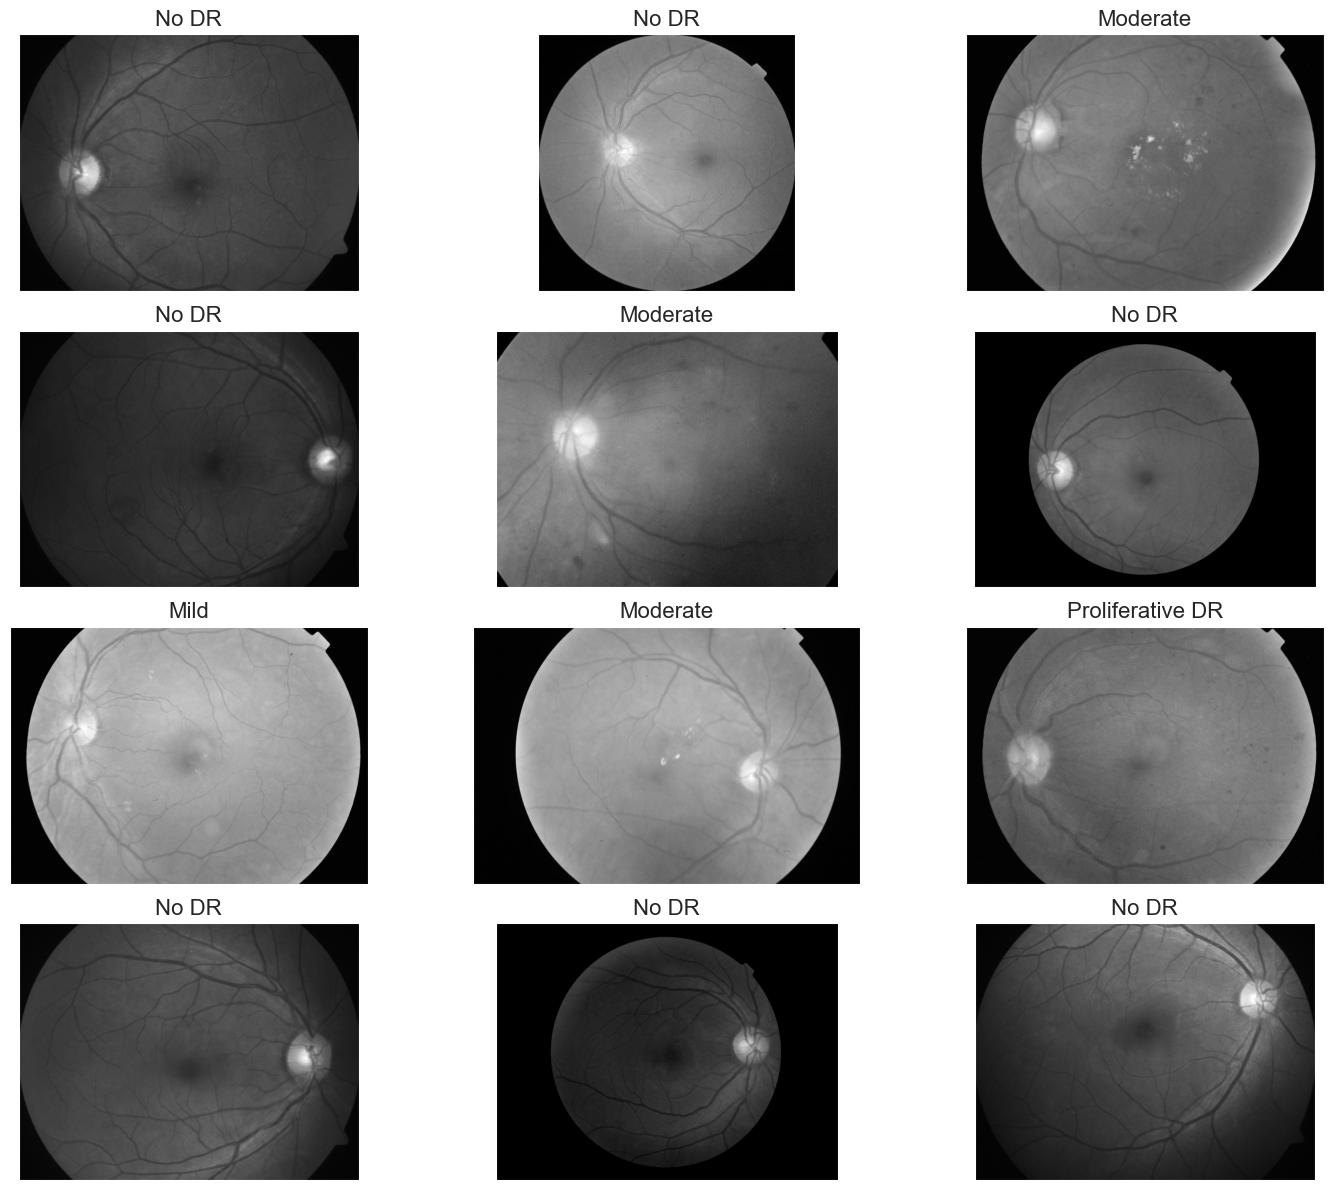

In [11]:
prev_images(n_rows, n_cols, train_img_path, rand_imgs, color_fltr=cv2.COLOR_BGR2GRAY)

Just like preprocessing is required before making any machine learning model. In the same way, removing noise in the image is important for further processing of the image. 

`GaussianBlur` makes any image smooth and remove the noises. I show the diference between GRAY scale images above, GRAY scale images applyed `GaussianBlu`, and a RGB image below. In my opinion, GRAY filter with `GaussianBlur` gives the most information. 

In [12]:
print(train_df.loc[train_df['id_code'] == rand_imgs[0].split('.')[0]])

           id_code  diagnosis
2212  9b57e43b44e7          0


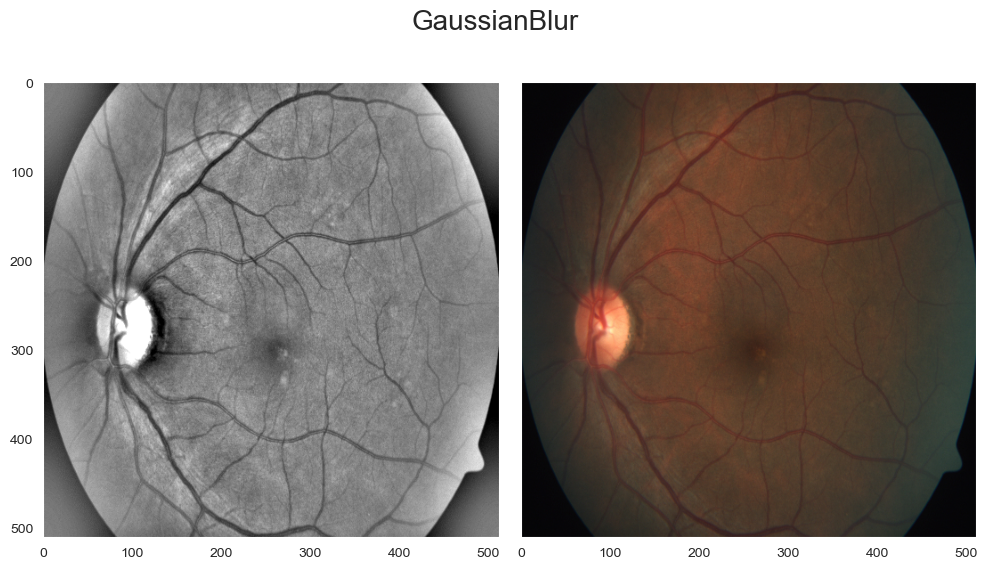

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), sharey=True)
tst = cv2.imread(os.path.join(train_img_path, rand_imgs[0]))
tstrgb = cv2.cvtColor(tst, cv2.COLOR_BGR2RGB)
tst = cv2.cvtColor(tst, cv2.COLOR_BGR2GRAY)
tst = cv2.resize(tst, (512, 512))
tst = cv2.addWeighted(tst, 4, cv2.GaussianBlur(tst, (0, 0), 25), -4, 128)
axs[0].imshow(tst, cmap='gray')
axs[0].grid(False)
axs[1].imshow(cv2.resize(tstrgb, (512, 512)))
axs[1].grid(False)
fig.suptitle('GaussianBlur', fontsize=20, y=0.85)
plt.tight_layout()
plt.show()

## Data Processing

Transforms are common image transformations available in the `torchvision.transform` module. 

In [181]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(contrast=(0, 8)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [182]:
# Custom Dataset for files
class CustomImageDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        """Is run once when instantiating the Dataset object"""
        # super().__init__()
        self.img_labels = labels_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in our dataset"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Returns a sample from the dataset at the given index idx"""
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}.png")
        image = torchvision.io.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [183]:
train_img_path = os.path.join(data_path, 'train_images/')
test_img_path = os.path.join(data_path, 'test_images/')

In [184]:
train_data = CustomImageDataset(labels_df=train_df, img_dir=train_img_path, transform=train_transforms)
train_dataloader = DataLoader(train_data, batch_size=32)

Feature batch shape:	torch.Size([32, 1, 224, 224])
Labels batch shape:	torch.Size([32])
<class 'torch.Tensor'>
torch.Size([224, 224])


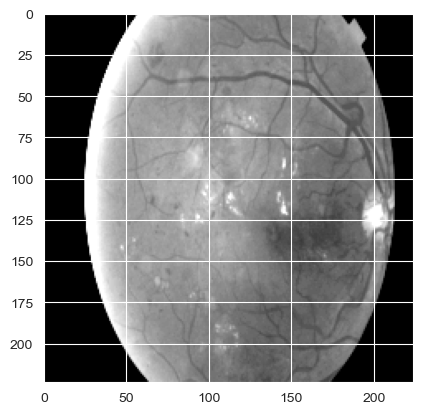

Label:	2


In [185]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape:\t{train_features.size()}')
print(f'Labels batch shape:\t{train_labels.size()}')

# Squeeze returns a tnesor with all the dimensions of input of size 1 removed.
img = train_features[0].squeeze()
print(type(img))
print(img.shape)
# print(img.permute(1, 2, 0).shape)
label = train_labels[0]

# Rearrange original tensor to show image
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label:\t{label}')